In [ ]:
!pip install pytesseract
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

In [ ]:
!pip install pillow

In [ ]:
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from keras.models import Model
import tensorflow as tf
import string

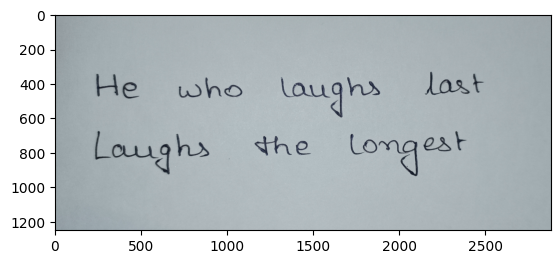

In [ ]:
# img = cv2.imread('/content/drive/MyDrive/image_segmentation_test5.jpg')
img = cv2.imread('/content/drive/MyDrive/laugh.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
def thresholding_img(image):
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, image = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

  plt.imshow(image)

  return image

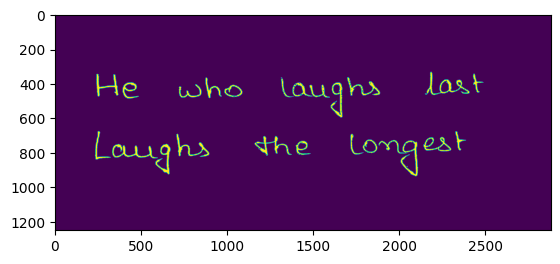

In [ ]:
thres_image = thresholding_img(img)

In [ ]:
def img_noise_reduction(image):
    kernel = np.ones((25,25), np.uint8)
    image = cv2.dilate(image, kernel, iterations=2)
    image = cv2.erode(image, kernel, iterations=2)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    # image = cv2.GaussianBlur(image, (3,3), 0)

    plt.imshow(image)

    return image

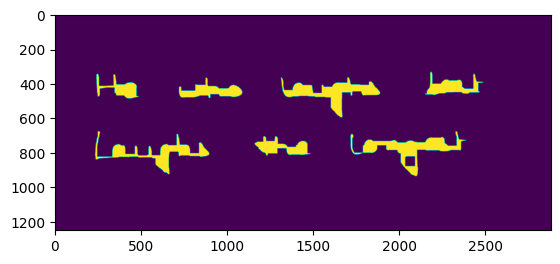

In [ ]:
nc_thres_image = img_noise_reduction(thres_image)

# With Pytesseract

In [ ]:
text = pytesseract.image_to_string(thres_image)
print(text)

He who Cr ae or

mOUSY LSS the Long ext



In [ ]:
data = pytesseract.image_to_data(thres_image, output_type='dict')
df = pd.DataFrame(data)

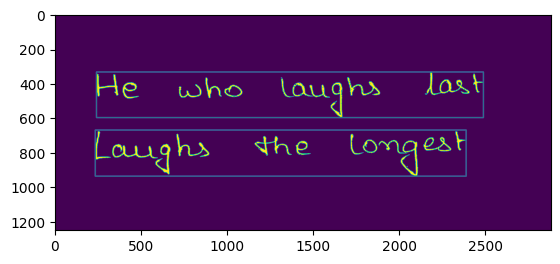

In [ ]:
lines = df[df['level']==4]
lines = lines.reset_index(drop=True)

image2 = thres_image.copy()
for i in range(len(lines)):

    cv2.rectangle(image2, (lines['left'].loc[i], lines['top'].loc[i]), (lines['left'].loc[i]+lines['width'].loc[i], lines['top'].loc[i]+lines['height'].loc[i]), (100,100,100), 5)

plt.imshow(image2)

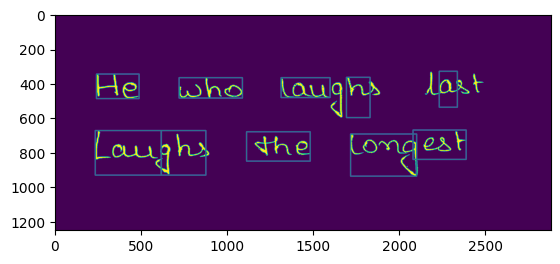

In [ ]:
words = df[df['level']==5]
words = words.reset_index(drop=True)
word_list = []
image3 = thres_image.copy()
for i in range(len(words)):

    cv2.rectangle(image3, (words['left'].loc[i], words['top'].loc[i]), (words['left'].loc[i]+words['width'].loc[i], words['top'].loc[i]+words['height'].loc[i]), (100,100,100), 5)
    word_list.append(thres_image[words['top'].loc[i]:words['top'].loc[i]+words['height'].loc[i], words['left'].loc[i]:words['left'].loc[i]+words['width'].loc[i]])

plt.imshow(image3)

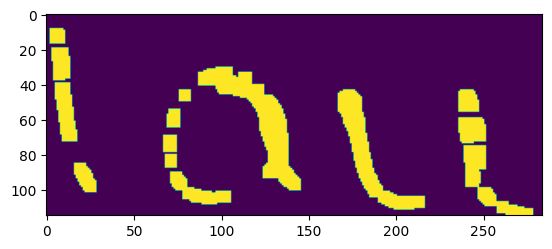

In [ ]:
chosen_word = word_list[2]
kernel2 = np.ones((0,6), np.uint8)
chosen_word = cv2.erode(chosen_word, kernel2, iterations=3)
kernel3 = np.ones((5,0), np.uint8)
chosen_word = cv2.dilate(chosen_word, kernel3, iterations=3)
plt.imshow(chosen_word)

# Without Pytesseract

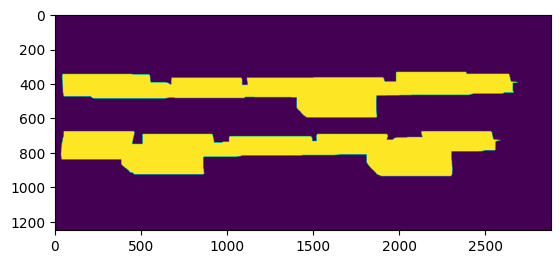

In [ ]:
for_lines = nc_thres_image.copy()

kernel = np.ones((1, 200), np.uint8)
for_lines = cv2.dilate(for_lines, kernel, iterations=2)
plt.imshow(for_lines)

In [ ]:
(contours, hierarchy) = cv2.findContours(for_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
line_contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[1])

In [ ]:
lines_blurred = []
lines = []

for i in line_contours:
    x, y, w, h = cv2.boundingRect(i)
    lines.append(thres_image[y:y+h, x:x+w])
    lines_blurred.append(nc_thres_image[y:y+h, x:x+w])


In [ ]:
all_words = []
for a in range(len(lines_blurred)):
    for_words = lines_blurred[a].copy()

    (contours, hierarchy) = cv2.findContours(for_words, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    words = []
    for i in word_contours:
        x, y, w, h = cv2.boundingRect(i)
        words.append(lines[a][y:y+h, x:x+w])

    all_words.append(words)

# Character split

In [ ]:
def rearrange_split(pts, w):
    if pts[0][0]>=20:
        pts = [[0]]+pts
    else:
        pts[0] = [pts[0][1]]

    if w - pts[len(pts)-1][1]>=20:
        pts.append([w])
    else:
        pts[len(pts)-1] = pts[len(pts)-1][0]

    flattened = []
    for i in pts:
        for j in i:
            flattened.append(j)

    rearranged = []
    for x in range(0,len(flattened)-1,2):
        rearranged.append([flattened[x], flattened[x+1]])

    return rearranged

In [ ]:
def get_splits(chosen_word, mean=0):

    # chosen_word = all_words[1][2]
    kernel2 = np.ones((1,7), np.uint8)
    chosen_word = cv2.erode(chosen_word, kernel2, iterations=1)
    kernel3 = np.ones((7,1), np.uint8)
    chosen_word = cv2.dilate(chosen_word, kernel3, iterations=1)
    chosen_word = cv2.GaussianBlur(chosen_word, (7,7), 0)




    h, w = chosen_word.shape

    vertical_profile = []

    for i in range(w-1):
        pixel_intensity = chosen_word[:h, i:i+1].sum()
        vertical_profile.append(pixel_intensity/200)

    vertical_profile = pd.Series(vertical_profile).rolling(3).mean()

    min_val_pts = [x for x,y in enumerate(vertical_profile) if y<=5]





    xx = [x for x,y in enumerate(vertical_profile) if y<5]
    diff = [0]*len(xx)

    chdf = pd.DataFrame({'points': xx, 'diff': diff})

    for id in range(1,len(chdf)):
        chdf['diff'].loc[id] = chdf['points'].loc[id] - chdf['points'].loc[id-1]

    i = 0
    split_pts = []
    while i<len(chdf)-2:
        pt = [chdf['points'].loc[i]]
        while True:
            if (chdf['diff'].loc[i+1]==1) and (i<len(chdf)-2):
                i+=1
                continue

            else:
                pt.append(chdf['points'].loc[i])
                i+=1
                break


        split_pts.append(pt)

    if chdf['diff'].loc[len(chdf)-1]>1:
        split_pts.append([chdf['points'].loc[len(chdf)-1], chdf['points'].loc[len(chdf)-1]])





    re_split = rearrange_split(split_pts, w)

    if mean==0:
        return re_split

    else:
        new_split_list = []
        for item in re_split:
            if item[1]-item[0]<100:
                new_split_list.append(item)
            else:
                div_no = int((item[1]-item[0])/mean)
                step = (item[1]-item[0])/div_no

                for i in range(div_no):
                    start = item[0] + i * step
                    end = start + step
                    new_split_list.append([round(start), round(end)])

        return new_split_list

In [ ]:
mean_char_width = 0

for _ in range(2):
    if mean_char_width==0:
        char_width = []
        for line in all_words:
            for word in line:
                list1 = get_splits(word)
                for wid in list1:
                    if wid[1]-wid[0]<100:
                        char_width.append(wid[1]-wid[0])

        mean_char_width = np.mean(char_width)
        std_dev = np.std(char_width)

    else:
        all_chars = []
        for line in all_words:
            word_char = []
            for word in line:
                x_split = get_splits(word, mean_char_width)
                height = word.shape[0]
                chars = []
                for ch in x_split:
                    chars.append(word[0:height, ch[0]:ch[1]])

                word_char.append(chars)

            all_chars.append(word_char)

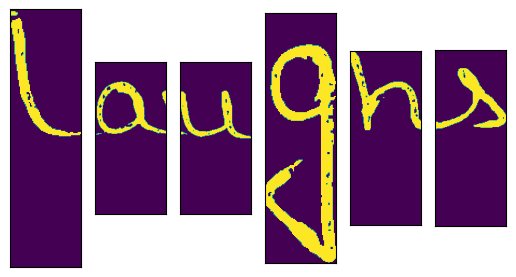

In [ ]:
word_chosen = all_chars[0][2]
for i, item in enumerate(word_chosen):
    plt.subplot(1,len(word_chosen), i+1)
    plt.imshow(item)
    plt.xticks([])
    plt.yticks([])

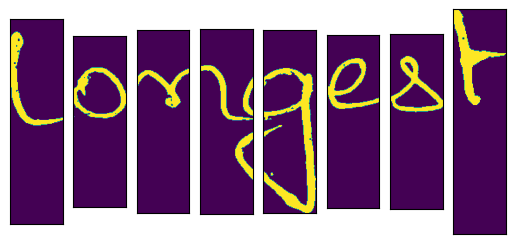

In [ ]:
word_chosen = all_chars[1][2]
for i, item in enumerate(word_chosen):
    plt.subplot(1,len(word_chosen), i+1)
    plt.imshow(item)
    plt.xticks([])
    plt.yticks([])

In [ ]:
# all_chars = []
# for line in all_words:
#     word_char = []
#     for word in line:
#         x_split = get_splits(word, mean_char_width)
#         height = word.shape[0]
#         chars = []
#         for ch in x_split:
#             chars.append(word[0:height, ch[0]:ch[1]])

#         word_char.append(chars)

#     all_chars.append(word_char)

In [ ]:
# height, width = chosen_word.shape

# character_list = []
# start_pt = 0
# size = 50
# offset = 25
# while True:
#     if (start_pt+size)<width:
#         character_list.append(chosen_word[0:height, start_pt:start_pt+size])
#         start_pt+=offset

#     else:
#         character_list.append(chosen_word[0:height, start_pt:width])
#         break

In [ ]:
# sbplt = len(character_list)
# plt.figure(figsize=(30,4))

# for i, item in enumerate(character_list):
#     plt.subplot(1, sbplt, i+1)
#     plt.imshow(item)